In [6]:
import os
from pathlib import Path
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
import seaborn as sns

import plotly.express as px


from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import ProbPlot


from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn import cluster
from sklearn.cluster import KMeans, MiniBatchKMeans
from kneed import KneeLocator
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.vq import kmeans
from scipy.spatial.distance import cdist,pdist
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

np.random.seed(54)




In [7]:
filename = 'data/cleaned_bitcoin_upto_2022-08-10.csv'
crypto = 'btc'

In [8]:
df = pd.read_csv(filename).drop_duplicates(subset = 'conversation_id')
#df = df[df['neutral'] != 1]
#pd.to_datetime(df["time"],format = '%H:%M:%S')
#df = df.drop('hashtags',inplace = True, axis = 1)

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values(by='date')
start = df['date'].iloc[0]
end = df['date'].iloc[-1] 
time_range = [start,end]


In [9]:
def compound_rate_func(x):
    threshold = 0.0
    
    if x < -threshold:
        return 'Negative'
        
    elif x >= -threshold and x <= threshold:
        return 'Neutral'
    
    else:
        return 'Positive'

df['compound_rate'] = df['compound'].apply(compound_rate_func)
df['percent_change'] = (df['close']-df['open'])/df['open']

scaler = MinMaxScaler()
df['compound_scaled'] = np.round((scaler.fit_transform(df[['compound']])*4)+1,0)




In [10]:
df

date  conversation_id    language  nlikes  nreplies  \
0      2022-08-01 00:00:00     1.553954e+18      french     2.0       0.0   
1      2022-08-01 00:00:00     1.553954e+18     english     1.0       0.0   
2      2022-08-01 00:00:00     1.553954e+18  vietnamese     1.0       0.0   
3      2022-08-01 00:00:00     1.553954e+18     english     0.0       0.0   
4      2022-08-01 00:00:00     1.553954e+18     english     0.0       0.0   
...                    ...              ...         ...     ...       ...   
546655 2022-08-09 23:59:25     1.557215e+18     english     0.0       0.0   
546656 2022-08-09 23:59:34     1.557215e+18     english     2.0       0.0   
546658 2022-08-09 23:59:35     1.557215e+18     english     0.0       0.0   
546657 2022-08-09 23:59:35     1.557215e+18     english     0.0       0.0   
546660 2022-08-09 23:59:50     1.557215e+18     english     0.0       0.0   

        nretweets                                              tweet  \
0             2.0  Web3 : une université de Hong Kong va lancer d...   
1             0.0                       Sell Bitcoin $BTC @ 23375.62   
2             0.0  1 $BTC = $23,356.30 $USD 🔴 -1.62% chg/24h  #Bi...   
3             0.0  AI trading session based on the DeepR BTC pred...   
4             0.0  You can claim #bitFlowers (PETAL) coin faucet ...   
...           ...                                                ...   
546655        0.0  What change story into history, and what turn ...   
546656        0.0  Bitcoin is a technological tour de force.  #GH...   
546658        0.0  Current #Cardano price Alert:   #ADA $0.5069 U...   
546657        0.0  Marathon Digital Posts Negative Q2 Results, bu...   
546660        0.0  BitcoinMagazine: RT @BitcoinMagazine: JUST IN:...   

              username  compound      open      high       low     close  \
0              EZCnews    0.0000  23296.36  23296.78  23262.27  23280.77   
1           BTC_AI_bot    0.0000  23296.36  23296.78  23262.27  23280.77   
2       BTCHourlyPrice    0.0000  23296.36  23296.78  23262.27  23280.77   
3            DeepR_BTC    0.4404  23296.36  23296.78  23262.27  23280.77   
4        eFlower_power   -0.4574  23296.36  23296.78  23262.27  23280.77   
...                ...       ...       ...       ...       ...       ...   
546655  educatorlouisz    0.0000  23137.22  23152.79  23135.09  23149.95   
546656  Kennethindab12    0.0000  23137.22  23152.79  23135.09  23149.95   
546658  CardanoTracker    0.2960  23137.22  23152.79  23135.09  23149.95   
546657   TimesOfUpdate   -0.3291  23137.22  23152.79  23135.09  23149.95   
546660     Benard_Wong    0.0000  23137.22  23152.79  23135.09  23149.95   

               volume      n_trades code compound_rate  percent_change  \
0       1659312059999  4.715691e+06  btc       Neutral       -0.000669   
1       1659312059999  4.715691e+06  btc       Neutral       -0.000669   
2       1659312059999  4.715691e+06  btc       Neutral       -0.000669   
3       1659312059999  4.715691e+06  btc      Positive       -0.000669   
4       1659312059999  4.715691e+06  btc      Negative       -0.000669   
...               ...           ...  ...           ...             ...   
546655  1660089599999  9.471611e+05  btc       Neutral        0.000550   
546656  1660089599999  9.471611e+05  btc       Neutral        0.000550   
546658  1660089599999  9.471611e+05  btc      Positive        0.000550   
546657  1660089599999  9.471611e+05  btc      Negative        0.000550   
546660  1660089599999  9.471611e+05  btc       Neutral        0.000550   

        compound_scaled  
0                   3.0  
1                   3.0  
2                   3.0  
3                   4.0  
4                   2.0  
...                 ...  
546655              3.0  
546656              3.0  
546658              4.0  
546657              2.0  
546660              3.0  

[410626 rows x 19 columns]

In [11]:
def create_spec_df(df,freq,crypto):
    df_count_col = ['tweet','nlikes','nreplies','nretweets']
    df_avg_col = ['open','close','high','low','volume','compound','compound_scaled','n_trades']

    df_counted = df[df['code'] == crypto].groupby(pd.Grouper(key='date', axis=0, freq=freq)).count()[['tweet']]
    df_counted['code'] = crypto
    df_summed = df[df['code'] == crypto].groupby(pd.Grouper(key='date', axis=0, freq=freq)).sum()[df_count_col[1:]]

    
    df_count = pd.concat([df_counted,df_summed],axis = 1)
    df_count.columns = ['nTweets','code', 'nlikes', 'nreplies', 'nretweets']





    df_averaged = df[df['code'] == crypto].groupby(pd.Grouper(key='date', axis=0, freq=freq)).mean()[df_avg_col]
    df_averaged.columns = ['open_avg','close_avg','high_avg','low_avg','volume_avg','compound_avg','compound_scaled_avg','n_trades_avg']

    


    

    df_averaged = df_averaged.reindex(['open_avg','close_avg','low_avg','high_avg',
                                             'volume_avg','n_trades_avg',
                                             'compound_avg','compound_scaled_avg']
                                            , axis=1)
    df_averaged['price_change'] = df_averaged['close_avg'] - df_averaged['open_avg']
    df_averaged['percent_change'] = 100 * df_averaged['price_change']/df_averaged['open_avg']
    
    df_averaged = df_averaged.round({"open_avg":2, "close_avg":2, "low_avg":2, "high_avg":2,'price_change':2, 'percent_change':2,'compound_scaled_avg':0})
    df_averaged['code'] = crypto


    df_ready = pd.concat([df_averaged,df_count], axis = 1)
    df_ready.reset_index(inplace = True)
    df_ready = df_ready.loc[:,~df_ready.columns.duplicated()].copy()

    return df_ready

In [12]:
df_day = create_spec_df(df,'D',crypto).reset_index()
#df_day_eth = create_spec_df(df,'D','eth')

#df_day = pd.concat([df_day_eth,df_day_btc], axis = 0).sort_values(by='date').reset_index()
#df_day = df_day.loc[:,~df_day.columns.duplicated()].copy()
if 'index' in df_day.columns:
    df_day.drop('index',inplace = True, axis = 1)



df_hour = create_spec_df(df,'H',crypto).reset_index()
#df_hour_eth = create_spec_df(df,'H','eth')

#df_hour = pd.concat([df_hour_eth,df_hour], axis = 0).sort_values(by='date').reset_index()
#df_hour = df_hour.loc[:,~df_hour.columns.duplicated()].copy()
if 'index' in df_hour.columns:
    df_hour.drop('index',inplace = True, axis = 1)


df_min = create_spec_df(df,'min',crypto).reset_index()
#df_min_eth = create_spec_df(df,'min','eth')

#df_min = pd.concat([df_min_eth,df_min], axis = 0).sort_values(by='date').reset_index()
#df_min = df_min.loc[:,~df_min.columns.duplicated()].copy()
if 'index' in df_min.columns:
    df_min.drop('index',inplace = True, axis = 1)

# Plotting

In [9]:
df_min

date  open_avg  close_avg   low_avg  high_avg  \
0     2022-08-01 00:00:00  23293.82   23286.04  23262.39  23300.19   
1     2022-08-01 00:01:00  23292.39   23304.96  23265.66  23317.69   
2     2022-08-01 00:02:00  23305.01   23284.10  23267.89  23306.87   
3     2022-08-01 00:03:00  23282.13   23278.05  23264.53  23294.05   
4     2022-08-01 00:04:00  23275.10   23272.71  23265.08  23287.80   
...                   ...       ...        ...       ...       ...   
12955 2022-08-09 23:55:00  23147.52   23150.23  23138.98  23155.60   
12956 2022-08-09 23:56:00  23149.45   23146.51  23143.84  23154.65   
12957 2022-08-09 23:57:00  23146.46   23141.24  23138.26  23147.75   
12958 2022-08-09 23:58:00  23142.37   23142.18  23134.09  23149.44   
12959 2022-08-09 23:59:00  23137.22   23149.95  23135.09  23152.79   

         volume_avg  n_trades_avg  compound_avg  compound_scaled_avg  \
0      1.659312e+12  4.530644e+06      0.097517                  3.0   
1      1.659312e+12  3.326528e+06      0.092610                  3.0   
2      1.659312e+12  2.608819e+06      0.083689                  3.0   
3      1.659312e+12  2.062340e+06      0.174514                  3.0   
4      1.659312e+12  1.632321e+06      0.022493                  3.0   
...             ...           ...           ...                  ...   
12955  1.660089e+12  1.096914e+06      0.271174                  4.0   
12956  1.660089e+12  8.433827e+05      0.162300                  3.0   
12957  1.660090e+12  9.963073e+05      0.178315                  3.0   
12958  1.660090e+12  1.010410e+06      0.087544                  3.0   
12959  1.660090e+12  9.471611e+05      0.001747                  3.0   

       price_change  percent_change code  nTweets  nlikes  nreplies  nretweets  
0             -7.78           -0.03  btc       92   655.0     250.0      141.0  
1             12.57            0.05  btc       31   402.0      40.0       24.0  
2            -20.91           -0.09  btc       27    25.0       2.0        1.0  
3             -4.08           -0.02  btc       28    48.0      19.0       16.0  
4             -2.39           -0.01  btc       29   223.0      37.0       22.0  
...             ...             ...  ...      ...     ...       ...        ...  
12955          2.71            0.01  btc       19     6.0       8.0        7.0  
12956         -2.94           -0.01  btc       19    34.0      12.0        5.0  
12957         -5.22           -0.02  btc       20    25.0      12.0        1.0  
12958         -0.19           -0.00  btc       16    20.0       5.0        3.0  
12959         12.73            0.06  btc       15    18.0       2.0        0.0  

[12960 rows x 16 columns]

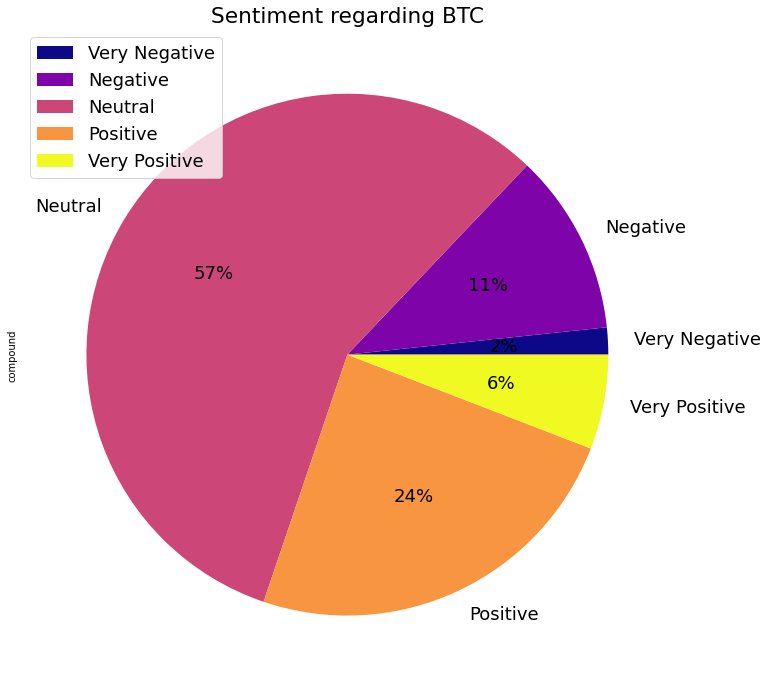

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (12,12))
plt.rcParams['font.size'] = 18
df_compound_scaled = df.groupby('compound_scaled').count()
df_compound_scaled.plot(kind='pie', y='compound', autopct='%1.0f%%',
                                cmap = 'plasma',
                                title='Sentiment regarding BTC', ax = ax,
                                labels = ['Very Negative','Negative','Neutral','Positive','Very Positive'])
plt.show()
plt.close()

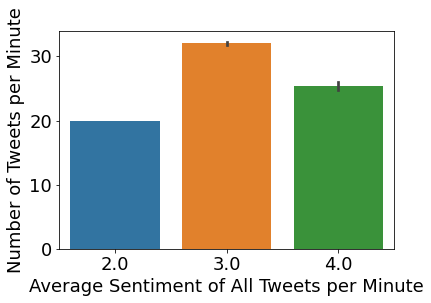

In [11]:
sns.barplot(data = df_min, x = 'compound_scaled_avg', y = 'nTweets')
plt.ylabel('Number of Tweets per Minute')
plt.xlabel('Average Sentiment of All Tweets per Minute')
plt.show()
plt.close()




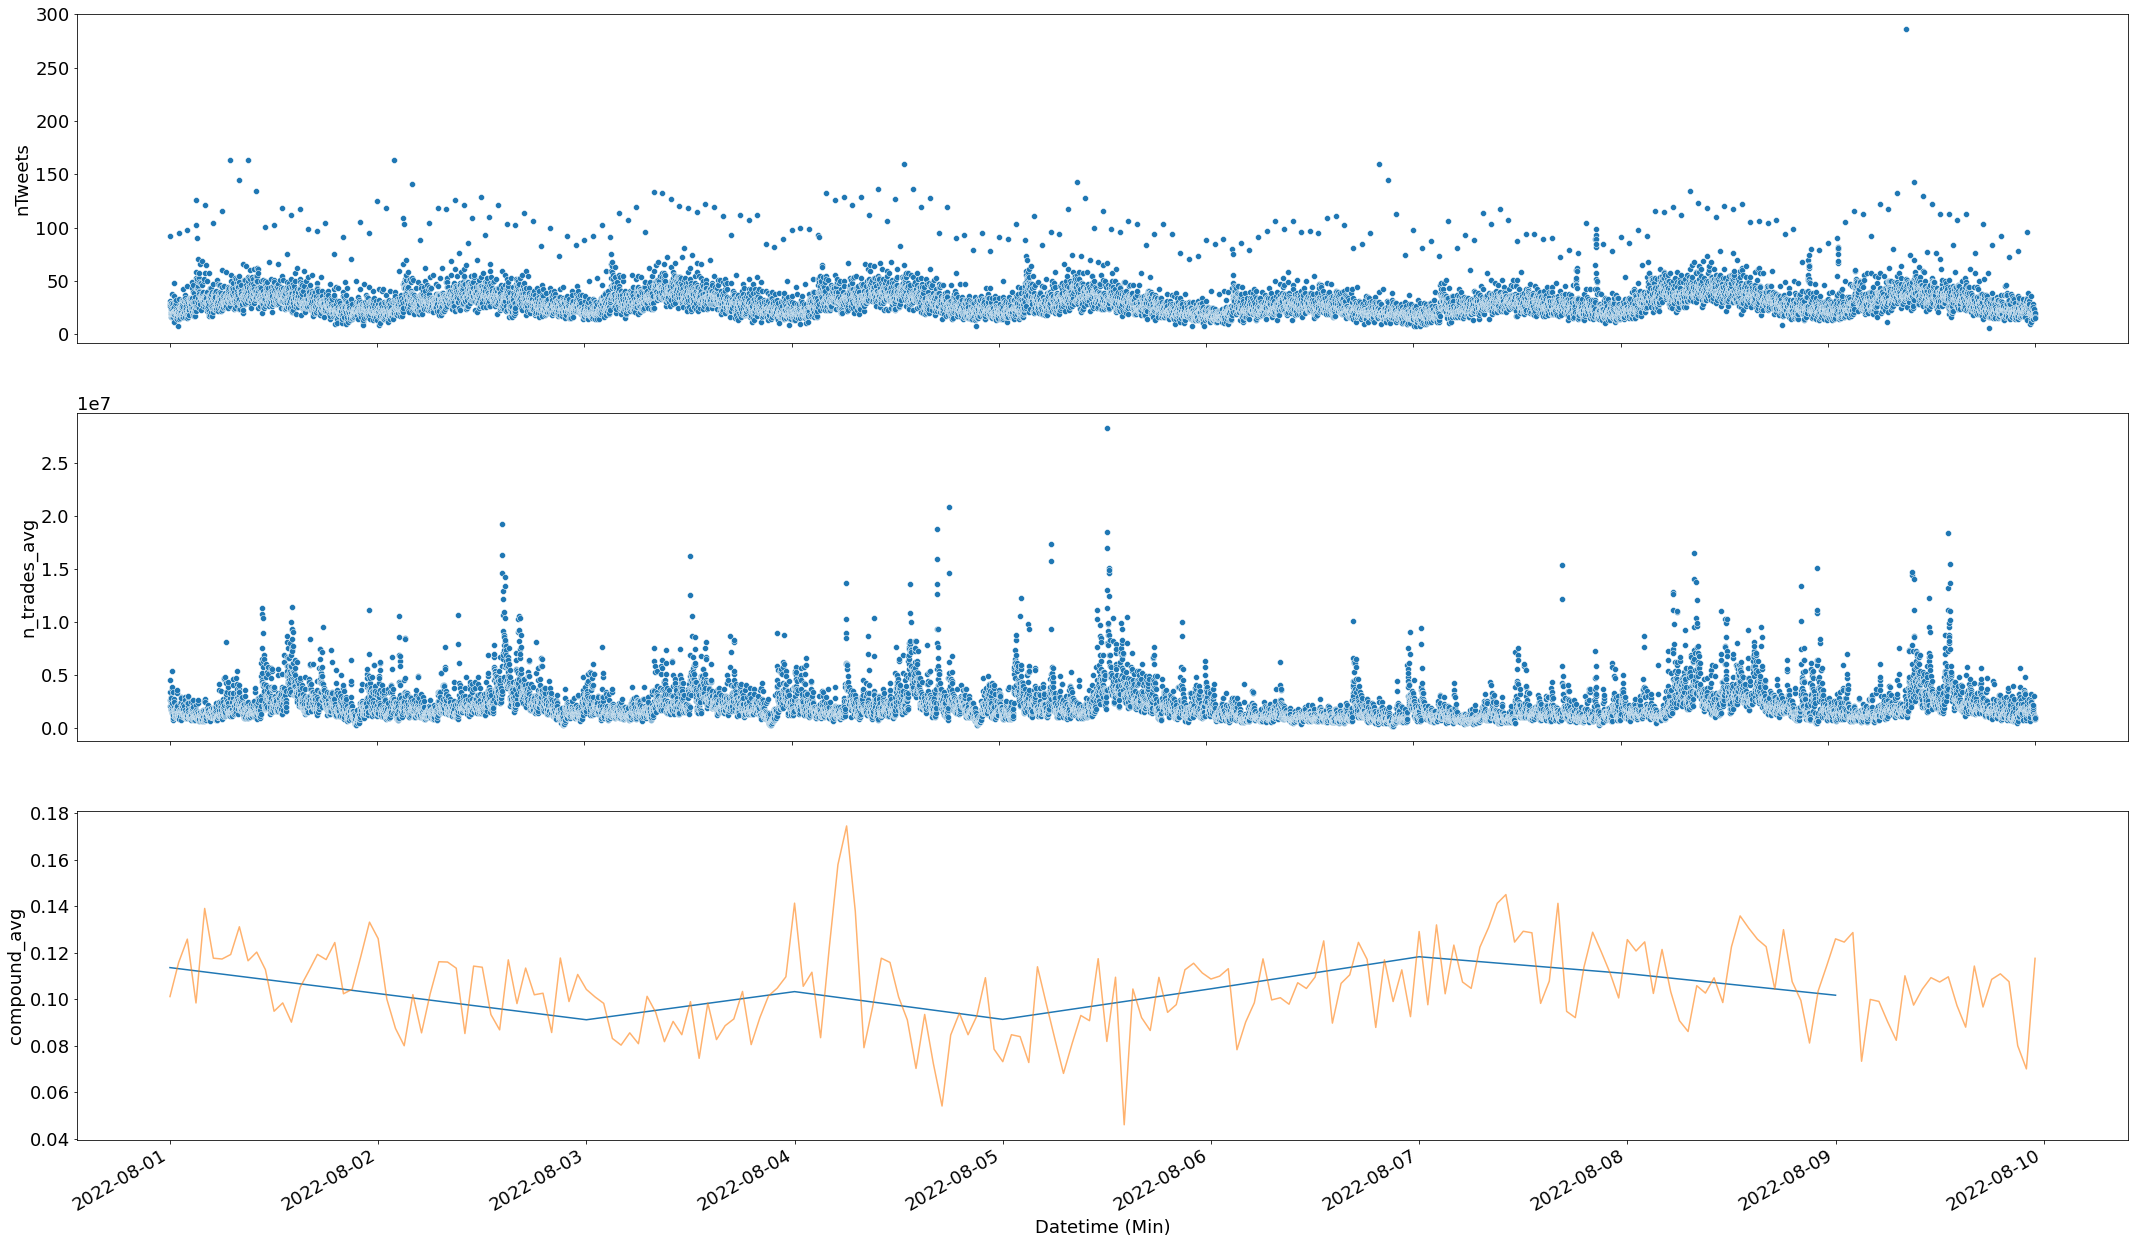

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize = (30,20))

#plt.plot()

day_line = sns.lineplot(data = df_day ,x = 'date', y = 'compound_avg', ax = ax[2], alpha = 1)
hour_line = sns.lineplot(data = df_hour ,x = 'date', y = 'compound_avg', ax = ax[2], alpha = 0.6, legend = False)
sns.scatterplot(data = df_min, x = 'date', y = 'nTweets', ax = ax[0])
sns.scatterplot(data = df_min, x = 'date', y = 'n_trades_avg', ax = ax[1])



plt.xlabel('Datetime (Min)')
fig.tight_layout()
fig.autofmt_xdate()

plt.show()


In [13]:
df_sec_tweet = df.groupby(pd.Grouper(key='date', axis=0, freq='s')).count()[['tweet']]
df_sec_compound = df.groupby(pd.Grouper(key='date', axis=0, freq='s')).mean()[['compound_scaled','n_trades']]
df_sec = pd.concat([df_sec_tweet,df_sec_compound],axis = 1)

df_sec = df_sec.round({'compound_scaled':0})


In [13]:
bar_fig = px.histogram(df_min, y = 'n_trades_avg', x = 'nTweets', color = 'compound_scaled_avg',
             height = 800, width = 1000,
             #title = f'Number of Trades of Each {crypto} in a 9 day Window (1-Aug-22 up until 10-Aug-22)', 
             labels={'percent_change':'Percent Change', 
                     'code': 'Cryptocurrency',
                    'nTweets':'Number of Tweets per second',
                    'compound_scaled_avg':'Sentiment'},marginal="rug") 
bar_fig.update_xaxes(title_text="Log Number of Tweets per Minute", type="log")
bar_fig.update_yaxes(title_text="Log Trade Count per Minute", type="log")
bar_fig.update_layout(barmode='overlay')



bar_fig.show()

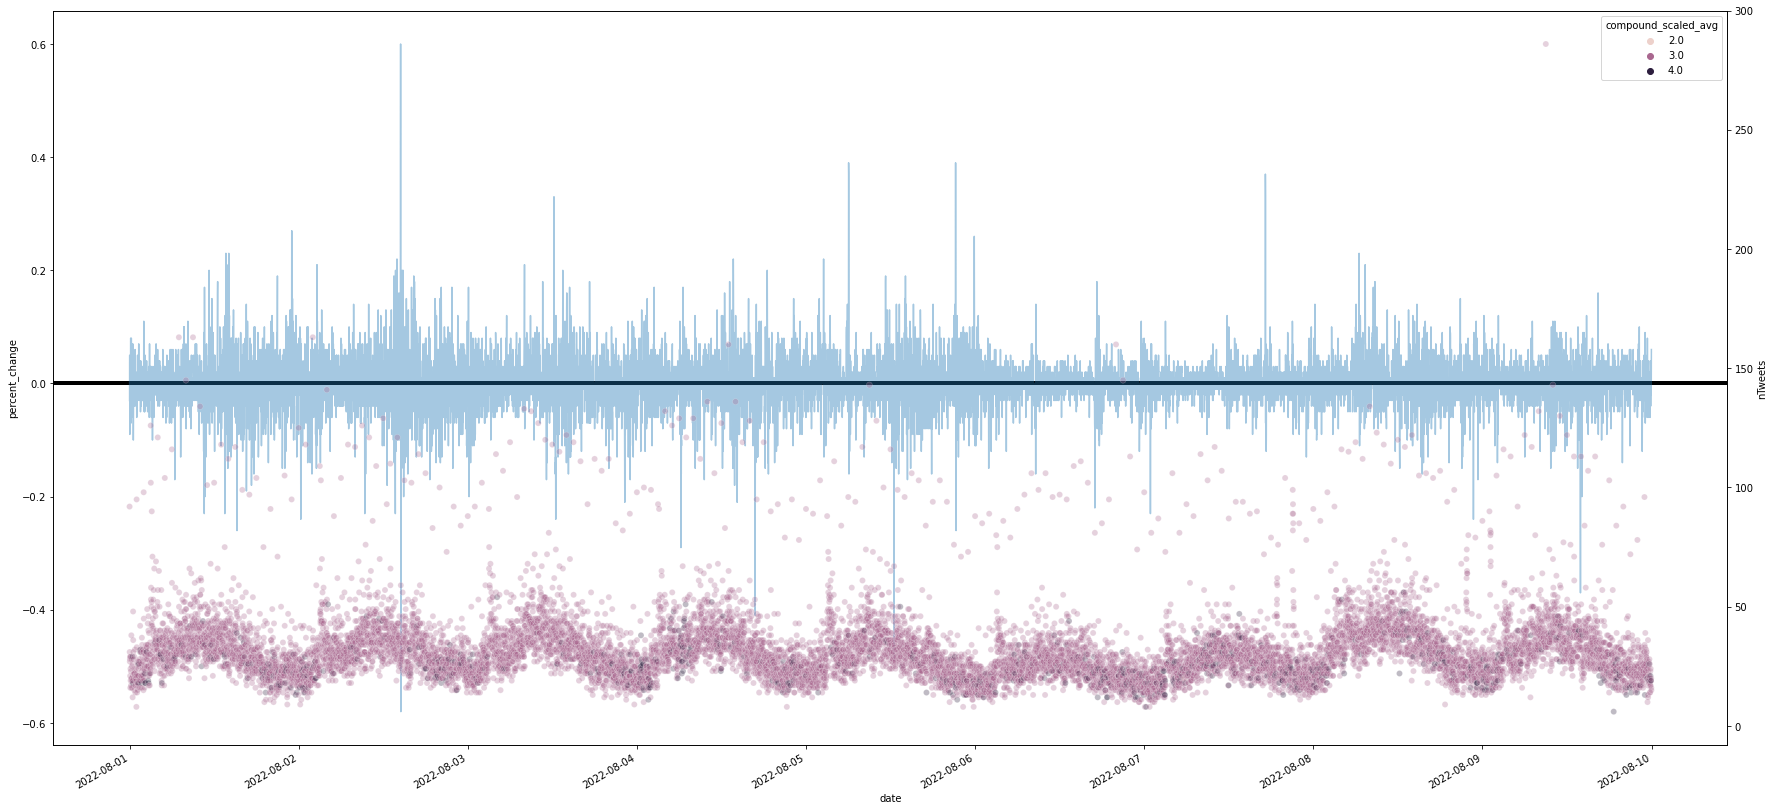

In [14]:
fig, ax2 = plt.subplots(figsize=(30,15))
plt.axhline(y=0, color='black', linestyle='-', linewidth = 4)

sns.set_palette("tab10")

sns.lineplot(data = df_min, x='date', y='percent_change', alpha=0.4, ax= ax2)
sns.scatterplot(data = df_min, x='date', y='nTweets', hue = 'compound_scaled_avg', alpha=0.3, ax= ax2.twinx())

fig.autofmt_xdate()



plt.show()

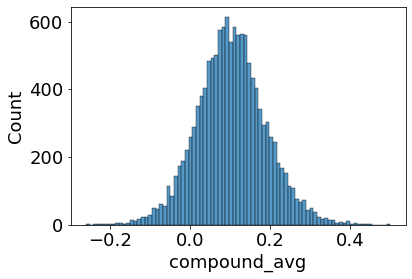

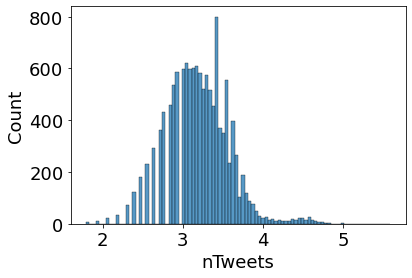

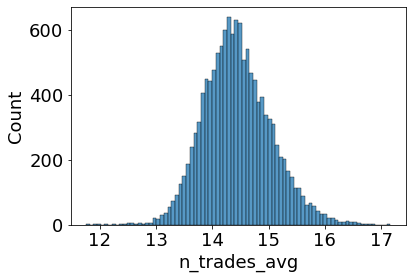

In [15]:
#for col in df_counted_hour:

sns.histplot(data = df_min, x = 'compound_avg')
plt.show()
plt.close()
sns.histplot(data = df_min, x = np.log1p((df_min['nTweets'])))
plt.show()
plt.close()
sns.histplot(data = df_min, x = np.log1p((df_min['n_trades_avg'])))
plt.show()
plt.close()


# Regression Modeling

In [ ]:
plt.rcParams['font.size'] = 14

In [56]:
from unicodedata import name


def regression_model(df,predictor_list,target,model = 'linear'):
    columns = []
    if len(predictor_list) > 1:
        for x in predictor_list:
            columns.append(x)
        columns.append(target)
    
    if(model == 'linear'):
        columns = []
        columns.append(predictor_list[0])
        columns.append(target)


        #fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (15,10))
        #ax[1].hist(df[predictor_list[0]])
        #plt.xlabel(predictor_list[0])
        #plt.ylabel('Frequency')

        #ax[2].hist(df[target])
        #plt.xlabel(target)
        #plt.ylabel('Frequency')


        #ax[0].scatter(df[predictor_list[0]],df[target])
        #plt.xlabel(predictor_list[0])
        #plt.ylabel(target)

        #plt.show()
        #plt.close()

    model_df = df.copy()[columns]
    
    selector = VarianceThreshold()
    model_df_c = pd.DataFrame(selector.fit_transform(model_df[columns]), columns = columns)
    print(model_df.head())
    print(model_df_c.head())


In [58]:
regression_model(df_min,['nTweets','n_trades_avg','compound_avg','volume_avg'],'high_avg','multiple')

   nTweets  n_trades_avg  compound_avg    volume_avg  high_avg
0       80  4.531261e+06      0.094887  1.659312e+12  23300.18
1       26  3.338261e+06      0.083577  1.659312e+12  23317.69
2       20  2.589597e+06      0.057570  1.659312e+12  23305.73
3       25  2.028855e+06      0.196488  1.659312e+12  23294.41
4       23  1.622300e+06     -0.007422  1.659312e+12  23286.90
   nTweets  n_trades_avg  compound_avg    volume_avg  high_avg
0     80.0  4.531261e+06      0.094887  1.659312e+12  23300.18
1     26.0  3.338261e+06      0.083577  1.659312e+12  23317.69
2     20.0  2.589597e+06      0.057570  1.659312e+12  23305.73
3     25.0  2.028855e+06      0.196488  1.659312e+12  23294.41
4     23.0  1.622300e+06     -0.007422  1.659312e+12  23286.90


### RMSE function

In [15]:
def rmse(predictions,actual):
    return np.sqrt(((predictions-actual) ** 2).mean())



In [16]:
df_min.columns

Index(['date', 'open_avg', 'close_avg', 'low_avg', 'high_avg', 'volume_avg',
       'n_trades_avg', 'compound_avg', 'compound_scaled_avg', 'price_change',
       'percent_change', 'code', 'nTweets', 'nlikes', 'nreplies', 'nretweets'],
      dtype='object')

In [18]:
df_min.corr().style.background_gradient()

## Simple Linear

In [19]:
target = 'high_avg'
predictor = 'nTweets'
regression_btc_lr = df_min[[target,predictor]]
regression_btc_lr

high_avg  nTweets
0      23300.19       92
1      23317.69       31
2      23306.87       27
3      23294.05       28
4      23287.80       29
...         ...      ...
12955  23155.60       19
12956  23154.65       19
12957  23147.75       20
12958  23149.44       16
12959  23152.79       15

[12960 rows x 2 columns]

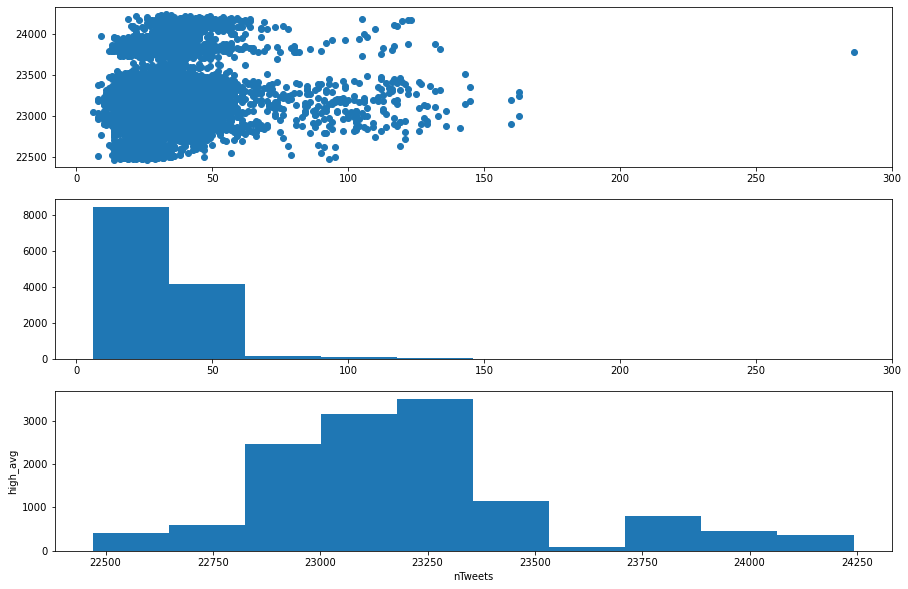

In [21]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (15,10))



ax[1].hist(regression_btc_lr[predictor])
plt.xlabel(predictor)
plt.ylabel('Frequency')

ax[2].hist(regression_btc_lr[target])
plt.xlabel(target)

ax[0].scatter(regression_btc_lr[predictor],regression_btc_lr[target])
plt.xlabel(predictor)
plt.ylabel(target)

plt.show()
plt.close()

In [22]:
selector = VarianceThreshold()
regression_btc_lr_c = selector.fit_transform(regression_btc_lr)
print(regression_btc_lr)
print(regression_btc_lr_c)

       high_avg  nTweets
0      23300.19       92
1      23317.69       31
2      23306.87       27
3      23294.05       28
4      23287.80       29
...         ...      ...
12955  23155.60       19
12956  23154.65       19
12957  23147.75       20
12958  23149.44       16
12959  23152.79       15

[12960 rows x 2 columns]
[[2.330019e+04 9.200000e+01]
 [2.331769e+04 3.100000e+01]
 [2.330687e+04 2.700000e+01]
 ...
 [2.314775e+04 2.000000e+01]
 [2.314944e+04 1.600000e+01]
 [2.315279e+04 1.500000e+01]]


In [24]:
Y = pd.DataFrame(regression_btc_lr[target])
X = pd.DataFrame(regression_btc_lr[predictor])
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               high_avg   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     229.5
Date:                Sun, 14 Aug 2022   Prob (F-statistic):           2.11e-51
Time:                        18:55:22   Log-Likelihood:                -93808.
No. Observations:               12960   AIC:                         1.876e+05
Df Residuals:                   12958   BIC:                         1.876e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.311e+04      7.245   3189.320      0.000    2.31e+04    2.31e+04
nTweets        3.1621      0.209     15.149      0.000       2.753       3.571
==============================================================================
Omnibus:                     1335.404   Durbin-Watson:                   0.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1812.111
Skew:                           0.845   Prob(JB):                         0.00
Kurtosis:                       3.708   Cond. No.                         85.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

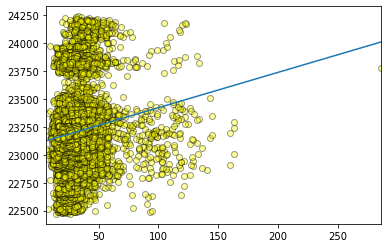

In [27]:
fig = sm.graphics.abline_plot(model_results = model)
ax = fig.axes[0]

plt.scatter(X[predictor],Y[target], color = 'yellow', alpha = 0.4, edgecolor = 'black')
plt.show()
plt.close()





In [28]:
#residual standard error of the model
print(f'residual standard error of the model: \t{np.sqrt(model.scale)}')
print(f'r-squared of the model:\t\t    \t {(model.rsquared)}')



residual standard error of the model: 	336.7831194566012
r-squared of the model:		    	 0.01740303833546064


In [29]:
x_fit = model.fittedvalues
residuals = model.resid

[Text(0.5, 1.0, 'Residuals of high average BTC price based on number of related tweets')]

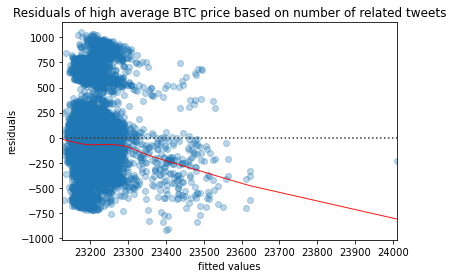

In [30]:
resid_plot = sns.residplot(x = x_fit, y = residuals, 
                    data=regression_btc_lr, 
                    lowess = True, 
                    scatter_kws = {'alpha': 0.3},
                    line_kws = {'color': 'red', 'lw': 1, 'alpha': 0.9})

#sns.scatterplot(x = ex_fitted, y = ex_residuals)
plt.xlabel('fitted values')
plt.ylabel('residuals')
resid_plot.set(title = 'Residuals of high average BTC price based on number of related tweets')

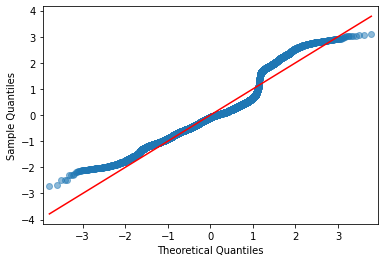

In [31]:
#checking to see if residuals are normally distributed
model_norm_residuals = model.get_influence().resid_studentized_internal
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line= 's', alpha = 0.5, lw = 1)

plt.show()
plt.close()

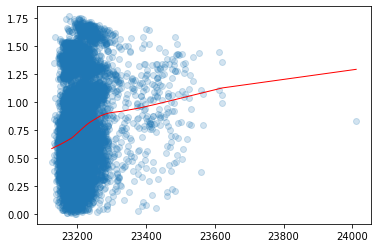

In [32]:
# checking if residuals have equal variance
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

plt.scatter(x= x_fit, y = model_norm_residuals_abs_sqrt, alpha = 0.2)

sns.regplot(x = x_fit, y = model_norm_residuals_abs_sqrt,
            scatter = False, 
            ci = False, 
            lowess = True,
            line_kws = {'color': 'red', 'lw': 1, 'alpha': 1})
plt.show()
plt.close()

In [33]:
test = model.outlier_test(method='bonf', alpha=0.05)

print(test)

print(regression_btc_lr.shape)
bonf_p_col = test['bonf(p)']
test_cut = test[bonf_p_col < 0.05]
print(test_cut)
drop_outliers = regression_btc_lr.drop(test_cut.index)
print(drop_outliers.shape)

       student_resid   unadj_p  bonf(p)
0          -0.288879  0.772679      1.0
1           0.336031  0.736853      1.0
2           0.341462  0.732761      1.0
3           0.294005  0.768758      1.0
4           0.266058  0.790199      1.0
...              ...       ...      ...
12955      -0.032590  0.974002      1.0
12956      -0.035411  0.971753      1.0
12957      -0.065288  0.947945      1.0
12958      -0.022713  0.981880      1.0
12959      -0.003376  0.997307      1.0

[12960 rows x 3 columns]
(12960, 2)
Empty DataFrame
Columns: [student_resid, unadj_p, bonf(p)]
Index: []
(12960, 2)


In [34]:
X2 = drop_outliers[predictor]
Y2 = drop_outliers[target]

X2 = sm.add_constant(X2)

model_2 = sm.OLS(Y2,X2).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:               high_avg   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     229.5
Date:                Sun, 14 Aug 2022   Prob (F-statistic):           2.11e-51
Time:                        18:56:16   Log-Likelihood:                -93808.
No. Observations:               12960   AIC:                         1.876e+05
Df Residuals:                   12958   BIC:                         1.876e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.311e+04      7.245   3189.320      0.0

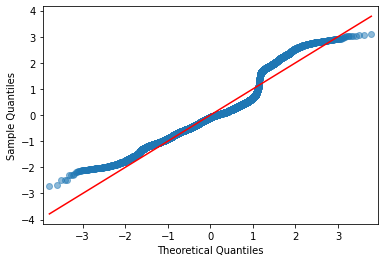

In [35]:
model_norm_residuals = model_2.get_influence().resid_studentized_internal
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line= 's', alpha = 0.5, lw = 1)



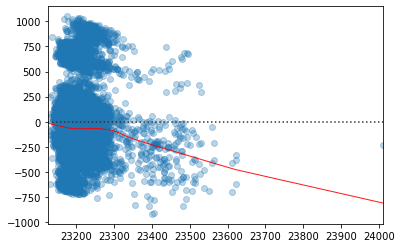

In [36]:
x_fit_2 = model_2.fittedvalues
sns.residplot(x = x_fit_2, y = model_2.resid, 
                    data=regression_btc_lr, 
                    lowess = True, 
                    scatter_kws = {'alpha': 0.3},
                    line_kws = {'color': 'red', 'lw': 1, 'alpha': 0.9})
plt.show()
plt.close()

## Multiple Linear

In [37]:
target = 'high_avg'
predictors = ['nTweets','percent_change','compound_avg']
col = ['nTweets','percent_change','compound_avg','high_avg']

In [38]:
regression_btc_ml = df_min[col]
regression_btc_ml

nTweets  percent_change  compound_avg  high_avg
0           92           -0.03      0.097517  23300.19
1           31            0.05      0.092610  23317.69
2           27           -0.09      0.083689  23306.87
3           28           -0.02      0.174514  23294.05
4           29           -0.01      0.022493  23287.80
...        ...             ...           ...       ...
12955       19            0.01      0.271174  23155.60
12956       19           -0.01      0.162300  23154.65
12957       20           -0.02      0.178315  23147.75
12958       16           -0.00      0.087544  23149.44
12959       15            0.06      0.001747  23152.79

[12960 rows x 4 columns]

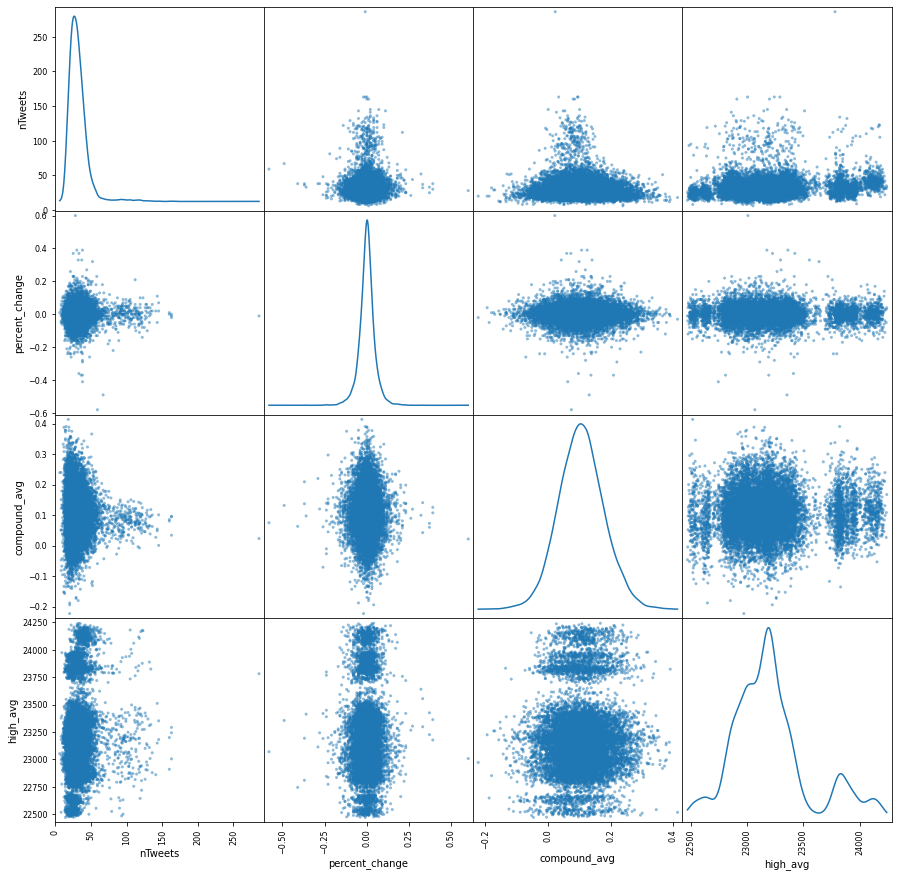

In [39]:
ax = scatter_matrix(regression_btc_ml,figsize=(15, 15), diagonal='kde')

plt.show()
plt.close()

In [40]:
selector = VarianceThreshold()
regression_btc_ml_c = selector.fit_transform(regression_btc_ml)
print(regression_btc_ml.shape)
print(regression_btc_ml_c.shape)

(12960, 4)
(12960, 4)


In [41]:
X = regression_btc_ml[predictors]
X = sm.add_constant(X)
Y = regression_btc_ml[target]

In [42]:
np.random.seed(54)
x_train_ml, x_test_ml, y_train_ml, y_test_ml = train_test_split(X, Y, test_size = 0.3)
print(x_train_ml.shape)
print(y_train_ml.shape)


print(x_test_ml.shape)
print(y_test_ml.shape)



(9072, 4)
(9072,)
(3888, 4)
(3888,)


In [43]:
model = sm.OLS(y_train_ml,x_train_ml).fit()
(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               high_avg   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     58.35
Date:                Sun, 14 Aug 2022   Prob (F-statistic):           2.36e-37
Time:                        18:56:19   Log-Likelihood:                -65676.
No. Observations:                9072   AIC:                         1.314e+05
Df Residuals:                    9068   BIC:                         1.314e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.308e+04     10.453   2208.269      0.000    2.31e+04    2.31e+04
nTweets            3.2300      0.251     12.845      0.000       2.737       3.723
percent_change     4.5380     73.914      0.061      0.951    -140.351     149.427
compound_avg     200.8948     49.004      4.100      0.000     104.836     296.954
==============================================================================
Omnibus:                      966.419   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1316.561
Skew:                           0.867   Prob(JB):                    1.30e-286
Kurtosis:                       3.689   Cond. No.                         724.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
fitted = model.fittedvalues
residuals = model.resid

model_norm_residuals = model.get_influence().resid_studentized_internal

#print(ex_model_m_norm_residuals)
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
#print(ex_model_m_norm_residuals_abs_sqrt)

model_m_abs_resid = np.abs(residuals)

training_data = pd.concat([x_train_ml,y_train_ml], axis = 1)



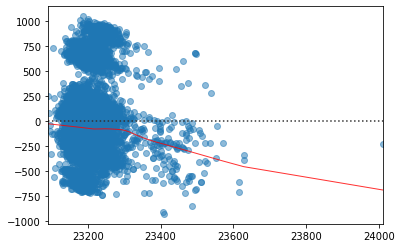

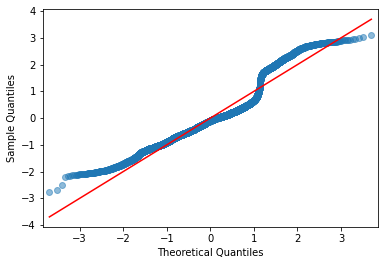

In [45]:
sns.residplot(x=fitted, y=residuals, data = training_data, 
                          lowess = True, 
                          scatter_kws = {'alpha': 0.5}, 
                          line_kws = {'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.show()
plt.close()


QQ = ProbPlot(model_norm_residuals)
QQ.qqplot(line = 's', alpha = 0.5, lw = 1)
plt.show()
plt.close()


In [46]:
test_outlier = model.outlier_test()
print(test_outlier)

filtered_out_outliers_test_index = test_outlier[test_outlier['bonf(p)']<0.05].index

print(test_outlier.shape)
print(filtered_out_outliers_test_index)

       student_resid   unadj_p  bonf(p)
9425       -0.050056  0.960079      1.0
8009       -0.031165  0.975139      1.0
6750       -0.894441  0.371110      1.0
8827       -0.691422  0.489318      1.0
12234       0.214938  0.829821      1.0
...              ...       ...      ...
5143       -0.379688  0.704186      1.0
12047       1.848007  0.064634      1.0
898         0.706315  0.480010      1.0
7493        0.039610  0.968405      1.0
7279        0.373596  0.708713      1.0

[9072 rows x 3 columns]
(9072, 3)
Int64Index([], dtype='int64')


In [47]:
x_train_ml_no_outliers = x_train_ml.drop(filtered_out_outliers_test_index)
y_train_ml_no_outliers = y_train_ml.drop(filtered_out_outliers_test_index)

y = y_train_ml_no_outliers
x = x_train_ml_no_outliers
model_no_outliers = sm.OLS(y,x).fit()

In [48]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
print(vif)




   VIF Factor        features
0    8.717581           const
1    1.005628         nTweets
2    1.000988  percent_change
3    1.006190    compound_avg


In [49]:
y_pred = np.array(model_no_outliers.predict(x_test_ml))
actual = np.array(y_test_ml)

residuals = y_pred-actual
results = pd.DataFrame({'actual':actual, 'predicted':y_pred,'residuals':residuals})

rmse_ml =  rmse(y_pred,actual)

In [50]:
rmse_ml

334.7509815630212

## LogLin

In [51]:
target = 'high_avg'
predictor = 'nTweets'
predictors = ['nTweets','percent_change','compound_avg']
col = ['nTweets','percent_change','compound_avg','high_avg']
regression_btc_loglin = df_min[col].copy()
regression_btc_loglin['log_high_avg'] = np.log1p(regression_btc_loglin['high_avg'])

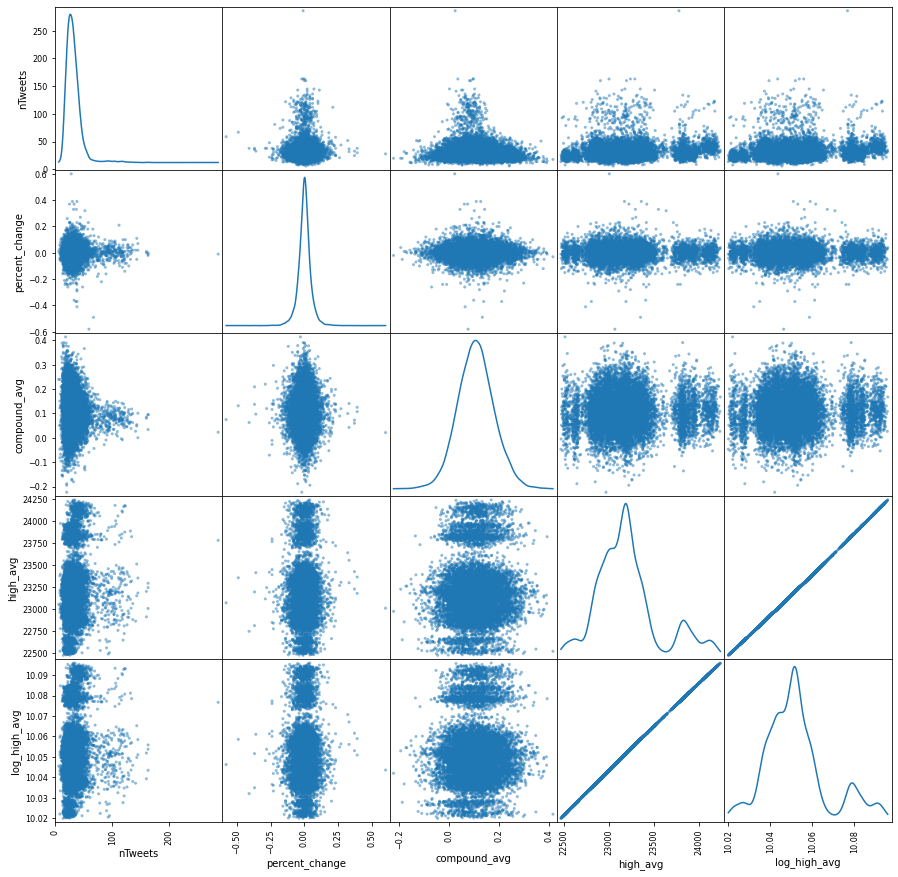

In [52]:
ax = scatter_matrix(regression_btc_loglin,figsize=(15, 15), diagonal='kde')

plt.show()
plt.close()

In [53]:
selector = VarianceThreshold()
regression_btc_loglin_c = selector.fit_transform(regression_btc_loglin)
print(regression_btc_loglin.shape)
print(regression_btc_loglin_c.shape)

(12960, 5)
(12960, 5)


In [54]:
regression_btc_loglin[predictors]
X = sm.add_constant(X)
Y = regression_btc_loglin['log_high_avg']


In [55]:
np.random.seed(54)
x_train_loglin, x_test_loglin, y_train_loglin, y_test_loglin = train_test_split(X, Y, test_size = 0.3)
print(x_train_loglin.shape)
print(y_train_loglin.shape)


print(x_test_loglin.shape)
print(y_test_loglin.shape)




(9072, 4)
(9072,)
(3888, 4)
(3888,)


In [56]:
model = sm.OLS(y_train_loglin,x_train_loglin).fit()
(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_high_avg   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     58.07
Date:                Sun, 14 Aug 2022   Prob (F-statistic):           3.56e-37
Time:                        18:56:51   Log-Likelihood:                 25576.
No. Observations:                9072   AIC:                        -5.114e+04
Df Residuals:                    9068   BIC:                        -5.111e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.0468      0.000   2.24e+04      0.000      10.046      10.048
nTweets            0.0001   1.08e-05     12.805      0.000       0.000       0.000
percent_change     0.0002      0.003      0.058      0.954      -0.006       0.006
compound_avg       0.0087      0.002      4.123      0.000       0.005       0.013
==============================================================================
Omnibus:                      888.706   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1181.596
Skew:                           0.825   Prob(JB):                    2.63e-257
Kurtosis:                       3.634   Cond. No.                         724.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
x_fitted = model.fittedvalues
residuals = model.resid

model_norm_residuals = model.get_influence().resid_studentized_internal

#print(ex_model_m_norm_residuals)
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
#print(ex_model_m_norm_residuals_abs_sqrt)

model_m_abs_resid = np.abs(residuals)

training_data = pd.concat([x_train_loglin,y_train_loglin], axis = 1)




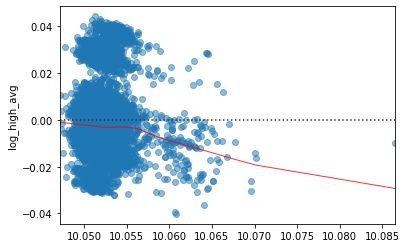

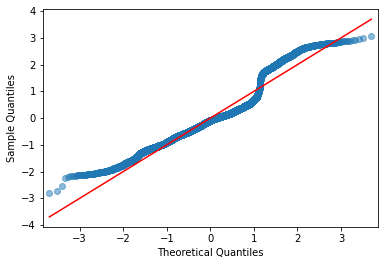

In [58]:
sns.residplot(x=x_fitted, y='log_high_avg', data = training_data, 
                          lowess = True, 
                          scatter_kws = {'alpha': 0.5}, 
                          line_kws = {'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.show()
plt.close()


QQ = ProbPlot(model_norm_residuals)
QQ.qqplot(line = 's', alpha = 0.5, lw = 1)
plt.show()
plt.close()



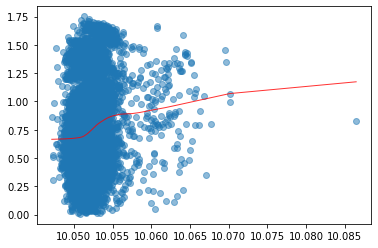

In [59]:
plt.scatter(x_fitted, model_norm_residuals_abs_sqrt, alpha = 0.5)
sns.regplot(x=x_fitted, y=model_norm_residuals_abs_sqrt, 
            scatter = False, 
            ci = False, 
            lowess = True,
            line_kws = {'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.show()
plt.close()

In [60]:
test = model.outlier_test()
print('Bad data points (bonf(p) < 0.05):\n', test[test['bonf(p)'] < 0.05])

test_f = test[test['bonf(p)'] < 0.05]


x_train_loglin_no_outliers = x_train_loglin.drop(test_f.index)
y_train_loglin_no_outliers = y_train_loglin.drop(test_f.index)

# Look at the shape of the new DataFrame, notice the rows have actually been dropped.
print(x_train_loglin_no_outliers.shape)

print(y_train_loglin_no_outliers.shape)



Bad data points (bonf(p) < 0.05):
 Empty DataFrame
Columns: [student_resid, unadj_p, bonf(p)]
Index: []
(9072, 4)
(9072,)


In [61]:
model_no_outliers = sm.OLS(y_train_loglin_no_outliers, x_train_loglin_no_outliers).fit()
model_no_outliers.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_high_avg   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     58.07
Date:                Sun, 14 Aug 2022   Prob (F-statistic):           3.56e-37
Time:                        18:57:23   Log-Likelihood:                 25576.
No. Observations:                9072   AIC:                        -5.114e+04
Df Residuals:                    9068   BIC:                        -5.111e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.0468      0.000   2.24e+04      0.000      10.046      10.048
nTweets            0.0001   1.08e-05     12.805      0.000       0.000       0.000
percent_change     0.0002      0.003      0.058      0.954      -0.006       0.006
compound_avg       0.0087      0.002      4.123      0.000       0.005       0.013
==============================================================================
Omnibus:                      888.706   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1181.596
Skew:                           0.825   Prob(JB):                    2.63e-257
Kurtosis:                       3.634   Cond. No.                         724.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
fitted_values_no_outliers = model_no_outliers.fittedvalues
print(fitted_values_no_outliers.head())

residuals_no_outliers = model_no_outliers.resid
print(residuals_no_outliers.head())


9425     10.050894
8009     10.052460
6750     10.055694
8827     10.053822
12234    10.052486
dtype: float64
9425    -0.000627
8009    -0.000345
6750    -0.012896
8827    -0.009954
12234    0.003229
dtype: float64


In [63]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_train_loglin_no_outliers.values, i) for i in range(x_train_loglin_no_outliers.shape[1])]
vif["features"] = x_train_loglin_no_outliers.columns
print(vif)


   VIF Factor        features
0    8.717581           const
1    1.005628         nTweets
2    1.000988  percent_change
3    1.006190    compound_avg


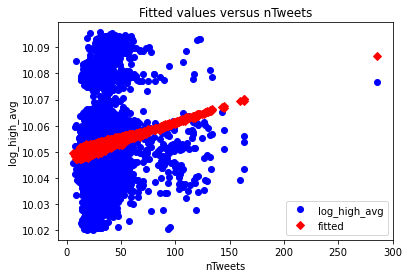

In [64]:
y_pred = model_no_outliers.predict(x_test_loglin)
model_no_outliers.params
sm.graphics.plot_fit(model_no_outliers,1, vlines=False)
plt.show()
plt.close()

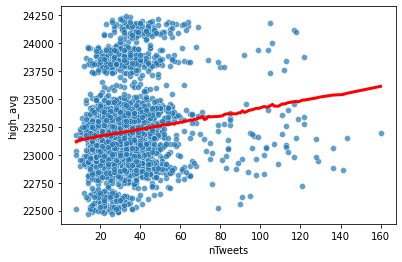

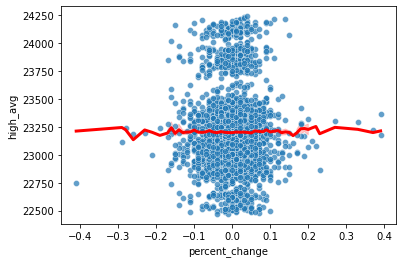

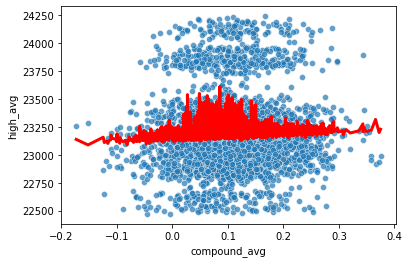

In [65]:
for col in x_test_loglin:
    if col != 'const':
        line = sns.lineplot(x = (x_test_loglin[col]), y = np.expm1(y_pred), color = 'red', linewidth = 3)
        scatter = sns.scatterplot(x = (x_test_loglin[col]), y = np.expm1(y_test_loglin), alpha = 0.7)
        
        scatter.set(xlabel = col,ylabel = 'high_avg')
        plt.show()
        plt.close()

In [66]:
y_pred = np.array(model_no_outliers.predict(x_test_loglin))
actual = np.array(y_test_loglin)

residuals = y_pred-actual
results = pd.DataFrame({'actual':actual, 'predicted':y_pred,'residuals':residuals})

rmse_loglin = rmse(y_pred,actual)
rmse_loglin

0.014338502038524579

## LogLog

In [67]:
target = 'high_avg'
predictor = 'nTweets'
predictors = ['nTweets','percent_change','compound_avg']
log_predictors = ['log_nTweets','log_percent_change','log_compound_avg']
col = ['nTweets','percent_change','compound_avg','high_avg']
regression_btc_loglog = df_min[col].copy()
regression_btc_loglog['log_high_avg'] = np.log1p(regression_btc_loglog['high_avg'])
regression_btc_loglog['log_nTweets'] = np.log1p(regression_btc_loglog['nTweets'])
regression_btc_loglog['log_percent_change'] = np.log1p(regression_btc_loglog['percent_change'])
regression_btc_loglog['log_compound_avg'] = np.log1p(regression_btc_loglog['compound_avg'])


regression_btc_loglog

nTweets  percent_change  compound_avg  high_avg  log_high_avg  \
0           92           -0.03      0.097517  23300.19     10.056260   
1           31            0.05      0.092610  23317.69     10.057010   
2           27           -0.09      0.083689  23306.87     10.056546   
3           28           -0.02      0.174514  23294.05     10.055996   
4           29           -0.01      0.022493  23287.80     10.055728   
...        ...             ...           ...       ...           ...   
12955       19            0.01      0.271174  23155.60     10.050035   
12956       19           -0.01      0.162300  23154.65     10.049994   
12957       20           -0.02      0.178315  23147.75     10.049696   
12958       16           -0.00      0.087544  23149.44     10.049769   
12959       15            0.06      0.001747  23152.79     10.049914   

       log_nTweets  log_percent_change  log_compound_avg  
0         4.532599           -0.030459          0.093051  
1         3.465736            0.048790          0.088569  
2         3.332205           -0.094311          0.080371  
3         3.367296           -0.020203          0.160855  
4         3.401197           -0.010050          0.022244  
...            ...                 ...               ...  
12955     2.995732            0.009950          0.239941  
12956     2.995732           -0.010050          0.150401  
12957     3.044522           -0.020203          0.164085  
12958     2.833213           -0.000000          0.083922  
12959     2.772589            0.058269          0.001745  

[12960 rows x 8 columns]

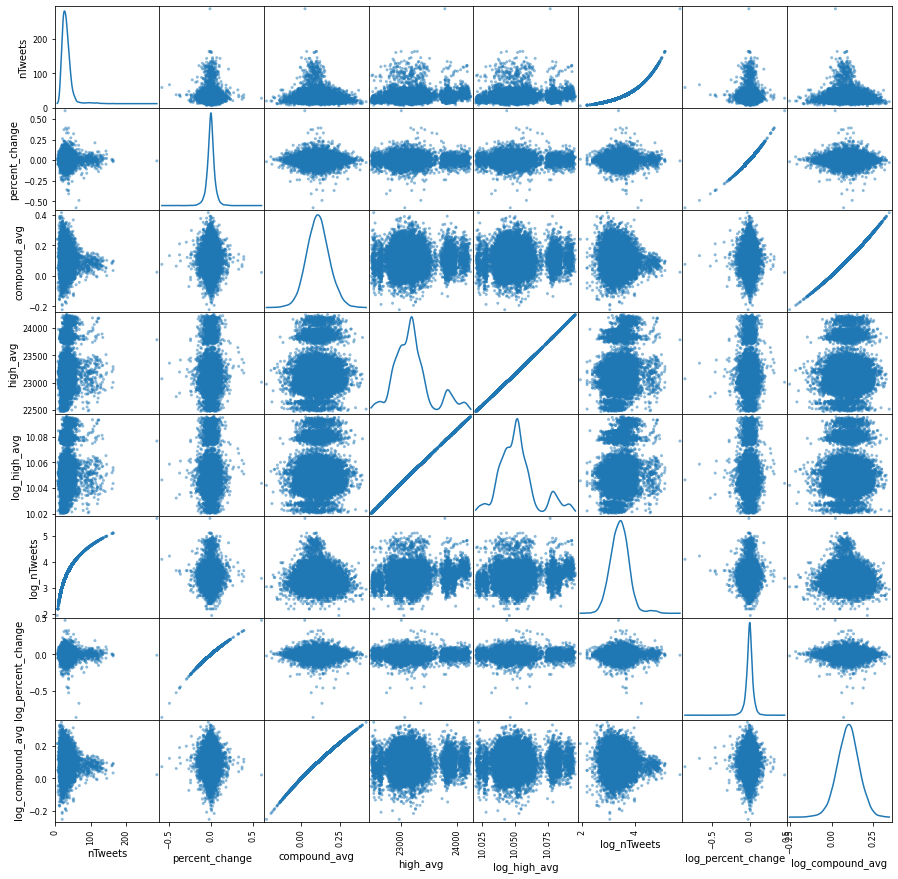

In [68]:
ax = scatter_matrix(regression_btc_loglog,figsize=(15, 15), diagonal='kde')

plt.show()
plt.close()

In [69]:
selector = VarianceThreshold()
regression_btc_loglog_c = selector.fit_transform(regression_btc_loglog)
print(regression_btc_loglog.shape)
print(regression_btc_loglog_c.shape)

(12960, 8)
(12960, 8)


In [70]:
X = regression_btc_loglog[log_predictors]
X = sm.add_constant(X)
Y = regression_btc_loglog['log_high_avg']

In [71]:
np.random.seed(54)
x_train_loglog, x_test_loglog, y_train_loglog, y_test_loglog = train_test_split(X, Y, test_size = 0.3)
print(x_train_loglog.shape)
print(y_train_loglog.shape)


print(x_test_loglog.shape)
print(y_test_loglog.shape)

model = sm.OLS(y_train_loglog,x_train_loglog).fit()
(model.summary())

(9072, 4)
(9072,)
(3888, 4)
(3888,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_high_avg   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     81.51
Date:                Sun, 14 Aug 2022   Prob (F-statistic):           4.95e-52
Time:                        18:57:33   Log-Likelihood:                 25610.
No. Observations:                9072   AIC:                        -5.121e+04
Df Residuals:                    9068   BIC:                        -5.118e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.0286      0.002   6624.271      0.000      10.026      10.032
log_nTweets            0.0066      0.000     15.254      0.000       0.006       0.007
log_percent_change     0.0009      0.003      0.283      0.777      -0.005       0.007
log_compound_avg       0.0100      0.002      4.349      0.000       0.005       0.015
==============================================================================
Omnibus:                      840.646   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1097.856
Skew:                           0.803   Prob(JB):                    4.01e-239
Kurtosis:                       3.570   Cond. No.                         73.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
x_fitted = model.fittedvalues
residuals = model.resid

model_norm_residuals = model.get_influence().resid_studentized_internal

#print(ex_model_m_norm_residuals)
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
#print(ex_model_m_norm_residuals_abs_sqrt)

model_m_abs_resid = np.abs(residuals)

training_data = pd.concat([x_train_loglog,y_train_loglog], axis = 1)



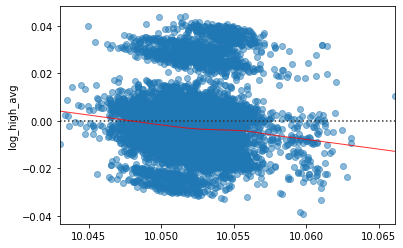

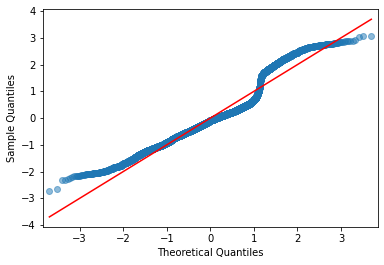

In [73]:
sns.residplot(x=x_fitted, y='log_high_avg', data = training_data, 
                          lowess = True, 
                          scatter_kws = {'alpha': 0.5}, 
                          line_kws = {'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.show()
plt.close()


QQ = ProbPlot(model_norm_residuals)
QQ.qqplot(line = 's', alpha = 0.5, lw = 1)
plt.show()
plt.close()





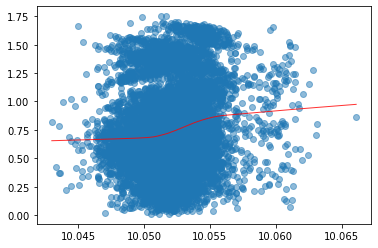

In [74]:
plt.scatter(x_fitted, model_norm_residuals_abs_sqrt, alpha = 0.5)
sns.regplot(x=x_fitted, y=model_norm_residuals_abs_sqrt, 
            scatter = False, 
            ci = False, 
            lowess = True,
            line_kws = {'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.show()
plt.close()
test = model.outlier_test()
print('Bad data points (bonf(p) < 0.05):\n', test[test['bonf(p)'] < 0.05])



In [ ]:
test_f = test[test['bonf(p)'] < 0.05]


x_train_loglog_no_outliers = x_train_loglog.drop(test_f.index)
y_train_loglog_no_outliers = y_train_loglog.drop(test_f.index)

# Look at the shape of the new DataFrame, notice the rows have actually been dropped.
print(x_train_loglog_no_outliers.shape)

print(y_train_loglog_no_outliers.shape)


In [ ]:
model_no_outliers = sm.OLS(y_train_loglog_no_outliers, x_train_loglog_no_outliers).fit()
model_no_outliers.summary()

In [ ]:
fitted_values_no_outliers = model_no_outliers.fittedvalues
print(fitted_values_no_outliers.head())

residuals_no_outliers = model_no_outliers.resid
print(residuals_no_outliers.head())


In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_train_loglog_no_outliers.values, i) for i in range(x_train_loglog_no_outliers.shape[1])]
vif["features"] = x_train_loglog_no_outliers.columns
print(vif)


In [ ]:
y_pred = np.array(model_no_outliers.predict(x_test_loglog))
actual = np.array(y_test_loglog)

residuals = y_pred-actual
results = pd.DataFrame({'actual':actual, 'predicted':y_pred,'residuals':residuals})

In [ ]:
y_pred = model_no_outliers.predict(x_test_loglog)
model_no_outliers.params
sm.graphics.plot_fit(model_no_outliers,1, vlines=False)
plt.show()
plt.close()

In [ ]:
for col in x_test_loglog:
    if col != 'const':
        scatter = sns.scatterplot(x = np.expm1(x_test_loglog[col]), y = np.expm1(y_test_loglog), alpha = 0.7)
        line = sns.scatterplot(x = np.expm1(x_test_loglog[col]), y = np.expm1(y_pred), color = 'red', linewidth = 0)


        
        scatter.set(xlabel = col[4:],ylabel = 'high_avg')
        plt.show()
        plt.close()


In [ ]:
rmse_loglog = rmse(y_pred,actual)
rmse_loglin

## Interaction

In [ ]:
target = 'high_avg'
predictor = 'nTweets'
predictors = ['nTweets','percent_change','compound_avg','nTweets:percent_change','nTweets:compound_avg','percent_change:compound_avg','nTweets:percent_change:compound_avg']
col = ['nTweets','percent_change','compound_avg','high_avg']
regression_btc_interaction = df_min[col].copy()

regression_btc_interaction['nTweets:percent_change'] = regression_btc_interaction['nTweets'] * regression_btc_interaction['percent_change'] 
regression_btc_interaction['nTweets:compound_avg'] = regression_btc_interaction['nTweets'] * regression_btc_interaction['compound_avg'] 
regression_btc_interaction['percent_change:compound_avg'] = regression_btc_interaction['percent_change'] * regression_btc_interaction['compound_avg'] 
regression_btc_interaction['nTweets:percent_change:compound_avg'] = regression_btc_interaction['nTweets:percent_change'] * regression_btc_interaction['compound_avg']


In [ ]:
ax = scatter_matrix(regression_btc_interaction,figsize=(30, 30), diagonal='kde')

plt.show()
plt.close()

In [ ]:
selector = VarianceThreshold()
regression_btc_interaction_c = selector.fit_transform(regression_btc_interaction)
print(regression_btc_interaction.shape)
print(regression_btc_interaction_c.shape)

In [ ]:
X = regression_btc_interaction[predictors]
X = sm.add_constant(X)
Y = regression_btc_interaction['high_avg']


In [ ]:
np.random.seed(54)
x_train_interaction, x_test_interaction, y_train_interaction, y_test_interaction = train_test_split(X, Y, test_size = 0.3)
print(x_train_interaction.shape)
print(y_train_interaction.shape)


print(x_test_interaction.shape)
print(y_test_interaction.shape)


In [ ]:
model = sm.OLS(y_train_interaction,x_train_interaction).fit()
(model.summary())

In [ ]:
x_fitted = model.fittedvalues
residuals = model.resid

model_norm_residuals = model.get_influence().resid_studentized_internal

#print(ex_model_m_norm_residuals)
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
#print(ex_model_m_norm_residuals_abs_sqrt)

model_m_abs_resid = np.abs(residuals)

training_data = pd.concat([x_train_interaction,y_train_interaction], axis = 1)

In [ ]:
sns.residplot(x=x_fitted, y='high_avg', data = training_data, 
                          lowess = True, 
                          scatter_kws = {'alpha': 0.5}, 
                          line_kws = {'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.show()
plt.close()


In [ ]:
QQ = ProbPlot(model_norm_residuals)
QQ.qqplot(line = 's', alpha = 0.5, lw = 1)
plt.show()
plt.close()

In [ ]:
plt.scatter(x_fitted, model_norm_residuals_abs_sqrt, alpha = 0.5)
sns.regplot(x=x_fitted, y=model_norm_residuals_abs_sqrt, 
            scatter = False, 
            ci = False, 
            lowess = True,
            line_kws = {'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.show()
plt.close()

In [ ]:
test = model.outlier_test()
print('Bad data points (bonf(p) < 0.05):\n', test[test['bonf(p)'] < 0.05])

test_f = test[test['bonf(p)'] < 0.05]


x_train_interaction_no_outliers = x_train_interaction.drop(test_f.index)
y_train_interaction_no_outliers = y_train_interaction.drop(test_f.index)

# Look at the shape of the new DataFrame, notice the rows have actually been dropped.
print(x_train_interaction_no_outliers.shape)

print(y_train_interaction_no_outliers.shape)

In [ ]:
model_no_outliers = sm.OLS(y_train_interaction_no_outliers, x_train_interaction_no_outliers).fit()
model_no_outliers.summary()

In [ ]:
fitted_values_no_outliers = model_no_outliers.fittedvalues
print(fitted_values_no_outliers.head())

residuals_no_outliers = model_no_outliers.resid
print(residuals_no_outliers.head())



In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_train_interaction_no_outliers.values, i) for i in range(x_train_interaction_no_outliers.shape[1])]
vif["features"] = x_train_interaction_no_outliers.columns
print(vif)



In [ ]:
y_pred = model_no_outliers.predict(x_test_interaction)
model_no_outliers.params
sm.graphics.plot_fit(model_no_outliers,1, vlines=False)
plt.show()
plt.close()


In [ ]:
for col in x_test_interaction:
    if col != 'const':
        scatter = sns.scatterplot(x = (x_test_interaction[col]), y = (y_test_interaction), alpha = 0.7, edgecolor = 'black')
        line = sns.scatterplot(x = (x_test_interaction[col]), y = (y_pred), color = 'r', linewidth = 0)


        
        scatter.set(xlabel = col,ylabel = 'high_avg')
        plt.show()
        plt.close()

In [ ]:
y_pred

In [ ]:
y_pred = np.array(model_no_outliers.predict(x_test_interaction))
actual = np.array(y_test_interaction)
residuals = y_pred-actual
results = pd.DataFrame({'actual':actual, 'predicted':y_pred,'residuals':residuals})

In [ ]:
rmse_int = rmse(y_pred,actual)
rmse_int

# Clustering

## K-Means

In [ ]:
df_min

In [ ]:
columns = ['date','nTweets', 'percent_change', 'compound_avg','high_avg']

In [ ]:
cluster_df_min = df_min.copy()
cluster_df_hour = df_hour.copy()


k_df_min = cluster_df_min.reset_index()[columns]
k_df_hour = cluster_df_hour.reset_index()[columns]

In [ ]:
fig = px.scatter_matrix(k_df_min, width = 1000, height = 1000, opacity = 0.4)
for t in fig.data:
    t.marker.line.width = 0.5
    t.marker.line.color = "black"

fig.show()


In [ ]:
fig1 = px.scatter(k_df_min, size = 'nTweets', color = 'compound_avg', y = 'percent_change', x = 'date', height = 750)
fig1.show()

In [ ]:
fig1 = px.scatter(k_df_hour, size = 'nTweets', color = 'compound_avg', y = 'percent_change', x = 'date', height = 750)
fig1.show()

In [ ]:
fig1 = px.scatter_3d(k_df_hour, size = 'nTweets', color = 'compound_avg', y = 'percent_change', x = 'date', z = 'high_avg',height = 750, width = 750)
for t in fig.data:
    t.marker.line.width = 0.5
    t.marker.line.color = "black"
fig1.show()

In [ ]:
k_df_min.drop('date',inplace = True, axis = 1)
scaler = MinMaxScaler()
k_df_min_scaled = scaler.fit_transform(k_df_min)
df_kmeans_min = pd.DataFrame(k_df_min_scaled, columns = k_df_min.columns)
(df_kmeans_min.head())

In [ ]:
kmeans_default = KMeans(n_clusters=2)
kmeans_default = kmeans_default.fit(df_kmeans_min)
ex_labels = kmeans_default.predict(df_kmeans_min)
C_default = kmeans_default.cluster_centers_

x = 3
y = 2

plt.scatter(df_kmeans_min.iloc[:,x],
            df_kmeans_min.iloc[:,y],
            c=kmeans_default.labels_,
            cmap='Set2',alpha = 0.3,edgecolors = 'black')

plt.scatter(C_default[:, x],
            C_default[:, y],
            c='black', edgecolors = 'white',
            s=200,
            alpha=0.7)

plt.xlabel(df_kmeans_min.columns[x])
plt.ylabel(df_kmeans_min.columns[y])



plt.show()
plt.close()


In [ ]:
kmeans_default = KMeans(n_clusters=2)
kmeans_default = kmeans_default.fit(df_kmeans_min)
ex_labels = kmeans_default.predict(df_kmeans_min)
C_default = kmeans_default.cluster_centers_

x = 0
y = 1

plt.scatter(df_kmeans_min.iloc[:,x],
            df_kmeans_min.iloc[:,y],
            c=kmeans_default.labels_,
            cmap='Set2',alpha = 0.3,edgecolors = 'black')

plt.scatter(C_default[:, x],
            C_default[:, y],
            c='black', edgecolors = 'white',
            s=200,
            alpha=0.5)

plt.xlabel(df_kmeans_min.columns[x])
plt.ylabel(df_kmeans_min.columns[y])



plt.show()
plt.close()



In [ ]:

# Set the range of k.
K_MAX = 10
KK = range(1,K_MAX+1)

# Run `kmeans` for values in the range k = 1-10.
KM = [kmeans(df_kmeans_min,k) for k in KK ]

# Find the centroids for each KM output. 
centroids = [cent for (cent,var) in KM]

# Calculate centroids for each iteration of k. 
D_k = [cdist(df_kmeans_min, cent, 'cosine') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]

tot_withinss = [sum(d**2) for d in dist]              # Total within-cluster sum of squares
totss = sum(pdist(df_kmeans_min)**2)/df_kmeans_min.shape[0]   # The total sum of squares
betweenss = totss - tot_withinss                      # The between-cluster sum of squares




In [ ]:
clr = cm.Spectral( np.linspace(0,1,10) ).tolist()

# Elbow curve - explained variance.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(KK, betweenss/totss*100, 'r*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained (%)')
plt.title('Elbow for KMeans clustering')




In [ ]:
 # Find the knee point in the curve.
kl = KneeLocator(x = KK, y = betweenss/totss*100,
                 curve='concave', 
                 direction='increasing', 
                 S=1)
                
kl.plot_knee()
elbow_cluster = kl.knee
print(elbow_cluster)




In [ ]:
obs = df_kmeans_min
silhouette_score_values=list()
 
NumberOfClusters = range(2,K_MAX)
 
for i in NumberOfClusters:
    
    classifier=cluster.KMeans(i,init='k-means++', n_init=10, 
                              max_iter=300, 
                              tol=0.0001, 
                              verbose=0, 
                              random_state=None, 
                              copy_x=True)
    classifier.fit(obs)
    labels= classifier.predict(obs)
    sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', sample_size=None, random_state=None)
    silhouette_score_values.append(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', sample_size=None, random_state=None))
 
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()     
 
sil_cluster=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]


print("Optimal number of components is:", sil_cluster)




In [ ]:

# Explained variance for default number of clusters.
print(betweenss[2 - 1]/totss * 100)

# Explained variance for optimal number of clusters.
print(betweenss[sil_cluster - 1]/totss * 100)





In [ ]:
# Setting optimal number of clusters.
optimal_clusters = max(elbow_cluster, sil_cluster)
# Initializing K-means.
kmeans_optimal = KMeans(n_clusters = optimal_clusters)
# Fitting with inputs.
kmeans_optimal = kmeans_optimal.fit(df_kmeans_min)
# Predicting the clusters.
labels = kmeans_optimal.predict(df_kmeans_min)
# Getting the cluster centers.
C_optimal = kmeans_optimal.cluster_centers_




In [ ]:

x = 3
y = 2

# First we plot our clusters, colored in by the labels.
plt.scatter(df_kmeans_min.iloc[:,x],            
            df_kmeans_min.iloc[:,y], 
            c = kmeans_optimal.labels_, 
            cmap = 'rainbow', alpha = 0.5, edgecolor = 'black')
# Second, we plot the optimized centroids over the clusters.
plt.scatter(C_optimal[:, x], 
            C_optimal[:, y], 
            c = 'black', 
            s = 200, 
            alpha = 0.7, edgecolor = 'white')

plt.xlabel(df_kmeans_min.columns[x])
plt.ylabel(df_kmeans_min.columns[y])





In [ ]:
cluster_df_min

In [ ]:
# Append the other variables back to the dataframe with clusters.
clustered_df_k = cluster_df_min.copy()
# Add cluster numbers.
clustered_df_k['clusters'] = np.array(labels)

# Inspect clusters.
(clustered_df_k.head(20))




In [ ]:

# Group by `clusters` column to see the group mean of each variable.
cluster_groups_means = clustered_df_k.groupby('clusters').mean()
print(cluster_groups_means)



In [ ]:
kmeans = KMeans(
        n_clusters=4, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
kmeans.fit(df_kmeans_min)

In [ ]:
clusters=pd.DataFrame(df_kmeans_min,columns=df_kmeans_min.columns)
clusters['label']=kmeans.labels_

In [ ]:
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])

In [ ]:
fig4 = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True,height=750,width=750)
fig4.show()

In [ ]:
pie=clusters.groupby('label').size().reset_index()
pie.columns=['label','value']
px.pie(pie,values='value',names='label')

## Hierarchical Clustering

In [ ]:
cluster_df_min

In [ ]:
columns = ['date','nTweets', 'percent_change', 'compound_avg','high_avg']
cluster_df_min = df_min
h_df_min = cluster_df_min.reset_index()[columns]
h_df_hour = cluster_df_min.reset_index()[columns]


if 'date' in h_df_hour.columns:
    h_df_hour.drop('date', axis = 1, inplace = True)

if 'date' in h_df_min.columns:
    h_df_min.drop('date', axis = 1, inplace = True)

In [ ]:
print(h_df_min.info())

scaler = MinMaxScaler()
df_cluster_scaled = scaler.fit_transform(h_df_min)
df_hier = pd.DataFrame(df_cluster_scaled, columns = h_df_min.columns)

df_dist = pdist(df_hier, 'cosine')
df_linked = linkage(df_dist, 'complete')


In [ ]:
plt.figure(figsize=(80, 10))  
plt.title('Hierarchical clustering dendrogram of BTC data')
dendrogram(df_linked,
           truncate_mode = 'lastp',   # select truncated mode
           p = len(h_df_min)/1000,                    # show only last p merged clusters
           show_leaf_counts = False,  # display leaf counts
           leaf_rotation = 90,        # set the angle of leaf label rotation
           leaf_font_size = 12,       # set the font size of leaf labels 
           show_contracted = True)    # display contracted nodes
plt.savefig('h_clustering.jpeg', dpi = 600)
plt.show()
plt.close()

In [ ]:
x = 'nTweets'
y = 'high_avg'
df_clusters = AgglomerativeClustering(n_clusters = 12,        
                                         affinity = 'cosine',
                                         linkage = 'complete')  

clusters = df_clusters.fit_predict(df_hier)
# Print the labels.
labels = (df_clusters.labels_) 
# Plot the clusters.
fig, ax = plt.subplots(figsize = (10,6))
plt.scatter(df_hier[x], 
            df_hier[y],
            alpha = 0.6,
            c = df_clusters.labels_, cmap = 'tab10', edgecolor = 'black', marker = 'o', s =40)
plt.legend(labels = np.array(clusters))
plt.xlabel(x)    
plt.ylabel(y)
plt.show()






In [ ]:
clustered_df_h= cluster_df_min.copy()
# Add cluster numbers.
clustered_df_h['clusters'] = np.array(clusters)



columns for .mean(): 
['open_avg', 'close_avg', 'low_avg', 'high_avg', 'volume_avg','compound_avg', 'compound_std', 'price_change', 'percent_change']
 
columns for .count():
['nTweets', 'nlikes', 'nreplies', 'nretweets']

In [ ]:
clustered_df_h.groupby('clusters').mean()[[col for col in cluster_df_min.columns if col != 'code']].sort_values(by=['percent_change','compound_avg'])

In [ ]:
clustered_df_h.groupby('clusters').mean()[[col for col in cluster_df_min.columns if col != 'code']].sort_values(by=['open_avg'])

In [ ]:
plt.figure(figsize=(12,8))


sns.jointplot(data=clustered_df_h, x='percent_change', y='high_avg',hue = 'clusters')

In [ ]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=clustered_df_h,
    x="percent_change", y="high_avg",
    hue="clusters", size="nTweets",
    palette=cmap, sizes=(10, 200),
)

In [ ]:
z = 'nTweets'
x = 'compound_avg'
y = 'percent_change'

plt.figure(figsize=(6,5))
#axes = plt.axes(projection='3d')
print(type(axes))



axes.set_xlabel(x)
axes.set_ylabel(y)
#axes.set_zlabel(z)
plt.legend(labels = np.array(clusters))



plt.show()

